In [1]:
pak::pkg_install("andywdahl/gxemm/GxEMM")
library(GxEMM)
ldak_loc  <- "/Genomics/grid/users/damelo/.local/bin/ldak5.linux "
if(!require(plyr)){install.packages("plyr"); library(plyr)}
if(!require(dplyr)){install.packages("dplyr"); library(dplyr)}
if(!require(magrittr)){install.packages("magrittr"); library(magrittr)}
if(!require(tidyr)){install.packages("tidyr"); library(tidyr)}
if(!require(ggplot2)){install.packages("ggplot2"); library(ggplot2)}
if(!require(cowplot)){install.packages("cowplot"); library(cowplot)}
if(!require(GGally)){install.packages("GGally"); library(GGally)}
if(!require(ggridges)){install.packages("ggridges"); library(ggridges)}

! Using bundled GitHub PAT. Please add your own PAT using `gitcreds::gitcreds_set()`.

ℹ Loading metadata database

✔ Loading metadata database ... done





ERROR: Error: [33m![39m error in pak subprocess
[1mCaused by error[22m: 
[33m![39m Could not solve package dependencies:
* [1mandywdahl/gxemm/GxEMM[22m: Can't install dependency msm
* [1mmsm[22m:
  * Can't install dependency survival
  * Can't install dependency expm
* [1mexpm[22m: Can't install dependency Matrix
* [1mMatrix[22m: Needs R >= 4.4.0
* [1mMatrix[22m: Needs R >= 4.5
* [1msurvival[22m: Can't install dependency Matrix
* [1msurvival[22m: Needs R >= 4.5


# Data input

In [4]:
expr_df = t(read.table("/Genomics/ayroleslab2/lamaya/bigProject/Datasets/GXEpaper/GeneCounts/VOOMCounts_CPM1_head_hsctrl_covfree_4svs_CORRECT_Jan8.21.txt",
                       row.names = 1))
rownames(expr_df) = gsub("^X", "", rownames(expr_df))

covariates = read.table("/Genomics/ayroleslab2/lamaya//bigProject/Datasets/GXEpaper/Covariates_forGEMMA_Jan82021.txt")
ID_C = row.names(covariates[covariates$treatment == 1,])
ID_HS = row.names(covariates[covariates$treatment == 2,])

Z_HS = as.numeric(rownames(expr_df) %in% ID_HS)
Z_C = as.numeric(rownames(expr_df) %in% ID_C)

GRM = as.matrix(read.table("/Genomics/ayroleslab2/lamaya/bigProject/Datasets/GXEpaper/GRM/head.hsc.final.norelatedness1.miss50.sXX.txt"))
rownames(GRM) = colnames(GRM) = rownames(expr_df)

# Writing data for GCTA run

In [45]:
x = expr_df[ID_C,]
out_df= data.frame(fam = NA, ID = rownames(x), x)
write.table(out_df, 
            "gcta/VOOMCounts_CPM1_head_ctrl_covfree_4svs_CORRECT_Jan8.21.txt", 
            quote = FALSE,
            col.names = FALSE, row.names = FALSE)

x = expr_df[ID_HS,]
out_df= data.frame(fam = NA, ID = rownames(x), x)
write.table(out_df, 
            "gcta/VOOMCounts_CPM1_head_hs_covfree_4svs_CORRECT_Jan8.21.txt", 
            quote = FALSE,
            col.names = FALSE, row.names = FALSE)

x = expr_df
out_df= data.frame(fam = NA, ID = rownames(x), x)
gxe = data.frame(fam = NA, ID = rownames(x), c("ctrl", "HS")[covariates$treatment])
write.table(out_df, 
            "gcta/VOOMCounts_CPM1_head_hsctrl_covfree_4svs_CORRECT_Jan8.21.txt",
            quote = FALSE,
            col.names = FALSE, row.names = FALSE)
write.table(gxe, 
            "gcta/HSC.gxe",
            quote = FALSE,
            col.names = FALSE, row.names = FALSE)

write.table(data.frame(colnames(expr_df)), file = "gcta/gene_list.csv", 
            quote = FALSE, col.names = FALSE, row.names = FALSE)

if(!require(genio)){install.packages("genio"); library(genio)}
write_grm("gcta/grm", kinship = GRM, 
          fam = data.frame(id = rownames(expr_df), fam = NA))

Writing: gcta/grm.grm.bin

Writing: gcta/grm.grm.id



In [42]:
x = expr_df
out_df = data.frame(fam = NA, ID = rownames(x), x)
gxe = data.frame(fam = NA, ID = rownames(x), c("ctrl", "HS")[covariates$treatment])

# Reading GxEMM results

In [6]:
results_folder = "~/projects/NEX-HS_C-GxE/data//output//GxEMM"
result_files = dir(results_folder)
results_meta = strsplit(result_files, "_")

index = as.numeric(sapply(results_meta, `[[`, 1))
gene = sapply(results_meta, `[[`, 2)
model = sapply(strsplit(sapply(results_meta, `[[`, 3), "\\."), `[[`, 1)
r_meta_df = data.frame(index, gene, model, file = result_files)

results_list = lapply(r_meta_df[,"file"], function(x) readRDS(file.path(results_folder, x)))
names(results_list) = r_meta_df[,2]

models_hom  = results_list[which(r_meta_df$model == "hom")]
models_iid  = results_list[which(r_meta_df$model == "iid")]
models_free = results_list[which(r_meta_df$model == "free")]

In [7]:
na_if = function(x){
    if(is.null(x)) NA_real_
    else x
}

genes = unique(r_meta_df$gene)
LL_all = ldply(genes, function(gene) 
    data.frame(gene = gene,
               hom  = na_if( models_hom[[gene]]$ll), 
               iid  = na_if( models_iid[[gene]]$ll), 
               free = na_if(models_free[[gene]]$ll)))
               
LL_complete = LL_all[complete.cases(LL_all),]

In [46]:
sapply(LL_all, function(x) sum(is.na(x))) + (8786 - nrow(LL_all))

gene  hom  iid free 
   5  197  562 2966

In [51]:
gxe_comparison = function(x, y){
    lr <- x - y
    pchisq( 2*lr, df=1, lower.tail=FALSE )
}
gxemm_pvals = data.frame(
    "iid x hom" = LL_complete %>% {gxe_comparison(.$iid, .$hom)},
    "free x hom" = LL_complete %>% {gxe_comparison(.$free, .$hom)},
    "free x iid" = LL_complete %>% {gxe_comparison(.$free, .$iid)})
gxemm_pvals$id = 1:nrow(gxemm_pvals)

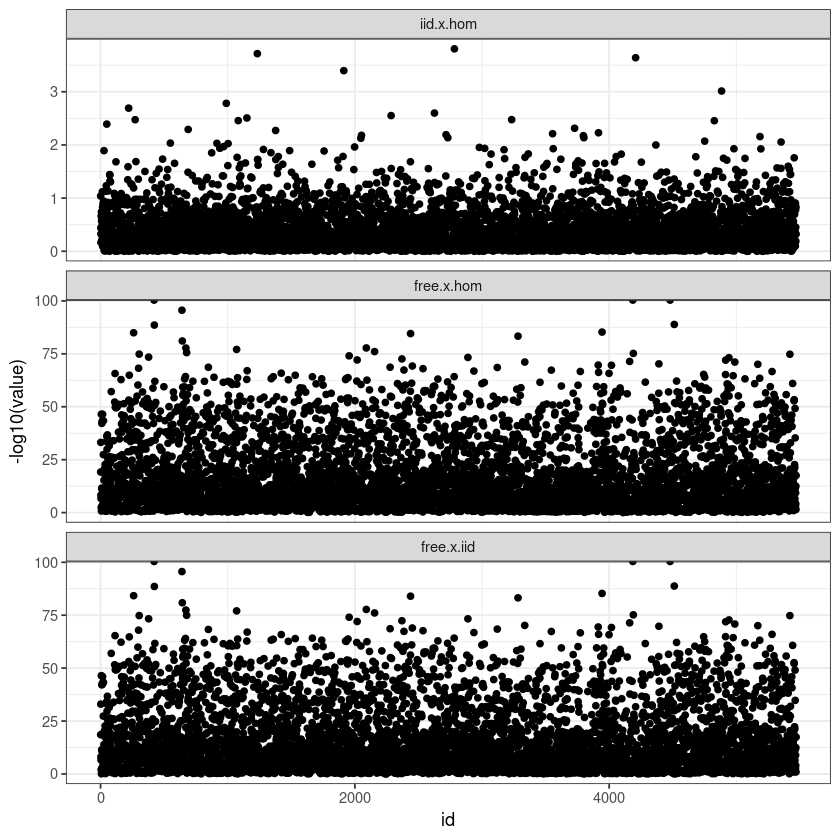

In [64]:
gxemm_pvals %>%
    pivot_longer(1:3) %>%
    mutate(name = factor(name, levels = c( "iid.x.hom", "free.x.hom", "free.x.iid"))) %>%
    ggplot(aes(id, -log10(value))) + geom_point() + 
    facet_wrap(~name, nrow = 3, scales = "free_y") +theme_bw()

In [132]:
h2_df = ldply(models_free, 
                function(x) data.frame(ctrl_gxemm = x$h2[[2]],
                                       HiSu_gxemm = x$h2[[1]] ))

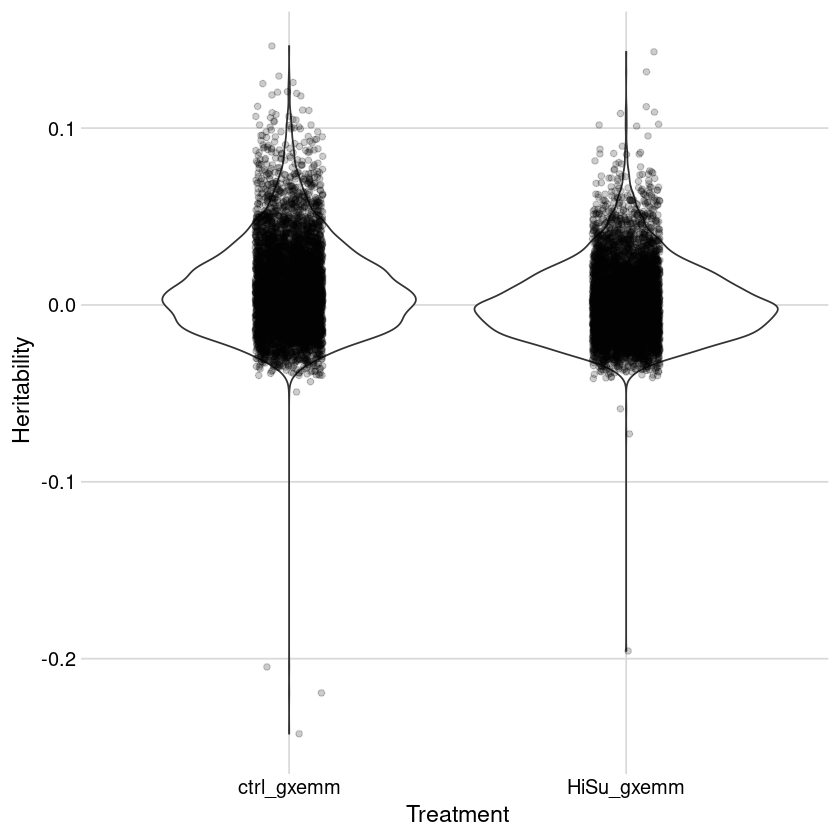

In [66]:
h2_df %>%
    pivot_longer(cols = ctrl_gxemm:HiSu_gxemm) %>%
    ggplot(aes(name, value, groups = name)) + 
    geom_violin() + geom_jitter(alpha = 0.2, width = 0.1) +
    labs(y = "Heritability", x = "Treatment") +     
    theme_minimal_grid()

In [73]:
results_folder = "~/projects/NEX-HS_C-GxE/data/output/gcta"
result_files = dir(results_folder, pattern = ".hsq")
results_meta = strsplit(result_files, "_")

In [74]:
index = as.numeric(sapply(results_meta, `[[`, 1))
gene = sapply(results_meta, `[[`, 2)
treatment = sapply(strsplit(sapply(results_meta, `[[`, 3), "\\."), `[[`, 1)
r_meta_df_gcta = data.frame(index, gene, treatment, file = result_files)

In [117]:
getGCTA_output_single = function(current_file, file){
    variance_table = matrix(NA, 4, 2)
    variance_table[1,] = as.numeric(current_file[5:6])
    variance_table[2,] = as.numeric(current_file[8:9])
    variance_table[3,] = as.numeric(current_file[11:12])
    variance_table[4,] = as.numeric(current_file[14:15])
    rownames(variance_table) = current_file[c(4, 7, 10, 13)]
    colnames(variance_table) = c("Estimate", "SE")
    stats = c(logL = current_file[17],
      logL0 = current_file[19],
      LRT = current_file[21], 
      df = current_file[23], 
     Pval = current_file[25], 
     n = current_file[27])
    list(var = variance_table, stats = stats)
}
getGCTA_output_all = function(current_file, file){
    variance_table = matrix(NA, 7, 2)
    variance_table[1,] = as.numeric(current_file[5:6])
    variance_table[2,] = as.numeric(current_file[8:9])
    variance_table[3,] = as.numeric(current_file[11:12])
    variance_table[4,] = as.numeric(current_file[14:15])
    variance_table[5,] = as.numeric(current_file[17:18])
    variance_table[6,] = as.numeric(current_file[20:21])
    variance_table[7,] = as.numeric(current_file[25:26])
    rownames(variance_table) = c(current_file[c(4, 7, 10, 13, 16, 19)], "Sum.V(G)/Vp")
    colnames(variance_table) = c("Estimate", "SE")
    stats = c(logL = current_file[28],
              logL0 = current_file[30],
              LRT = current_file[32], 
              df = current_file[34], 
              Pval = current_file[36], 
              n = current_file[38])
    list(var = variance_table, stats = stats)
}
getGCTA_output = function(gene, treatment = "ctrl", 
                          results_folder = "~/projects/NEX-HS_C-GxE/data/output/gcta"){
    file = r_meta_df_gcta[r_meta_df_gcta$gene == gene & 
                          r_meta_df_gcta$treatment == treatment,
                          "file"]
    current_file = scan(file.path(results_folder, file), character())
    if(treatment %in% c("hs", "ctrl")) return(getGCTA_output_single(current_file, file))
    if(treatment == "hsctrl") return(getGCTA_output_all(current_file, file))
}

In [118]:
models_ctrl = lapply(unique(r_meta_df_gcta$gene[r_meta_df_gcta$treatment=="ctrl"]), getGCTA_output)
models_HiSu = lapply(unique(r_meta_df_gcta$gene[r_meta_df_gcta$treatment=="hs"]), getGCTA_output, "hs")
models_HSxC = lapply(unique(r_meta_df_gcta$gene[r_meta_df_gcta$treatment=="hsctrl"]), getGCTA_output, "hsctrl")
names(models_ctrl) = names(models_HiSu) = unique(r_meta_df_gcta$gene)
names(models_HSxC) = unique(r_meta_df_gcta$gene[r_meta_df_gcta$treatment=="hsctrl"])

In [133]:
h2_df$ctrl_gcta = sapply(models_ctrl[h2_df$.id], function(x) x$var[4, 1])
h2_df$HiSu_gcta = sapply(models_HiSu[h2_df$.id], function(x) x$var[4, 1])
h2_df[,-1][h2_df[,-1] == 1e-6] = 0

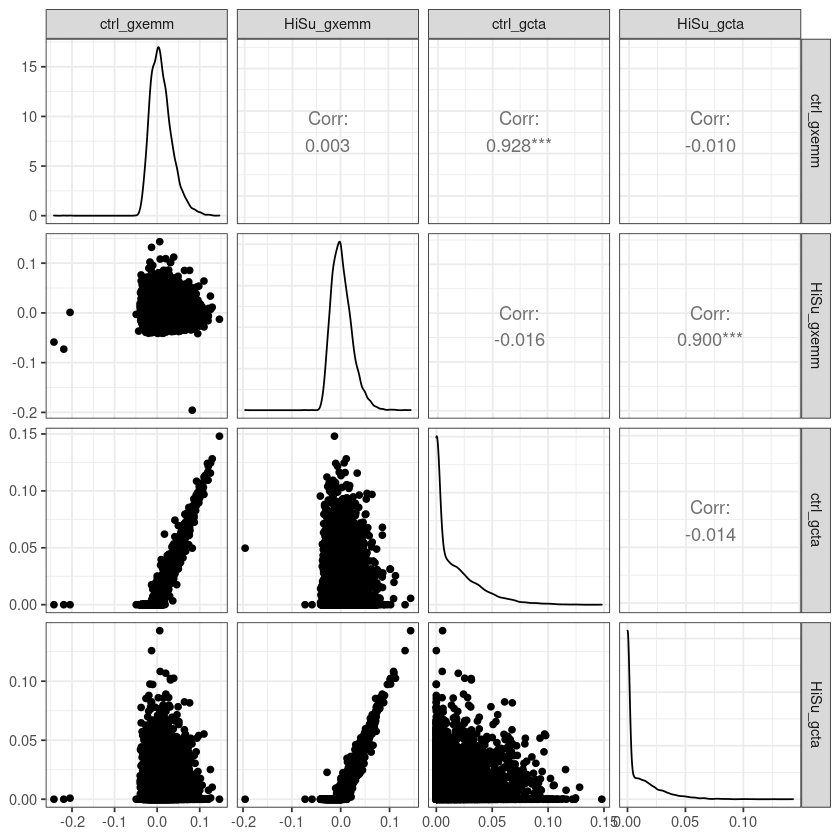

In [134]:
ggpairs(h2_df[,-1]) + theme_bw()

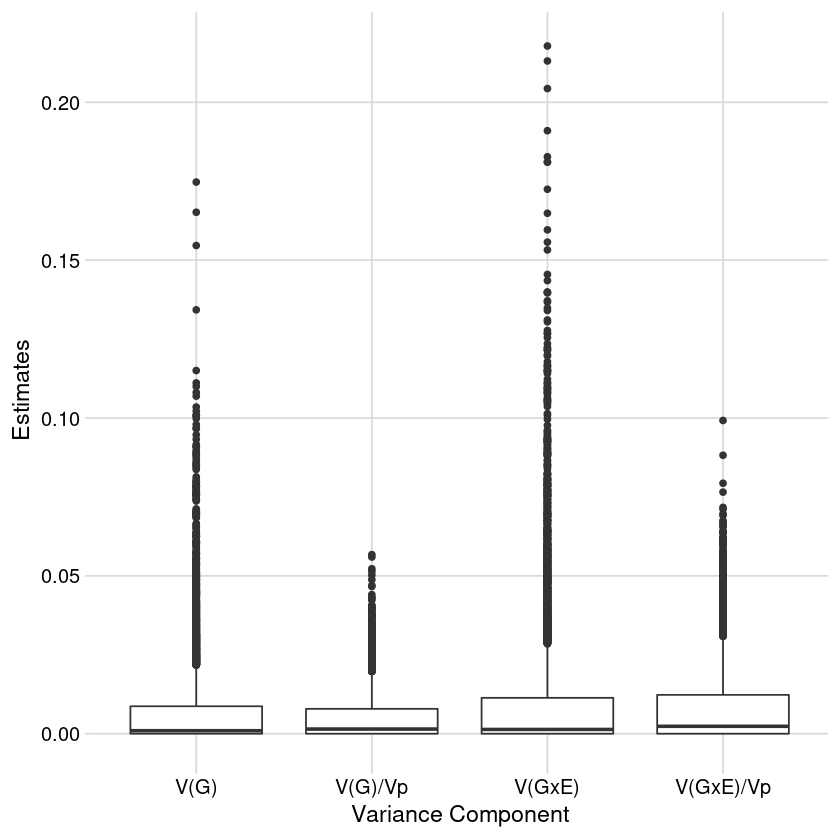

In [178]:
ldply(models_HSxC, function(x) x$var[,1]) %>%
      select(.id, 'V(G)', 'V(GxE)', 'V(G)/Vp', 'V(GxE)/Vp') %>%
      pivot_longer(cols = 2:ncol(.)) %>%
      ggplot(aes(name, value)) + 
      geom_boxplot() + theme_minimal_grid() + 
      labs(y = "Estimates", x = "Variance Component")

In [167]:
names(ldply(models_HSxC, function(x) x$var[,1]))

[1] ".id"         "V(G)"        "V(GxE)"      "V(e)"        "Vp"         
[6] "V(G)/Vp"     "V(GxE)/Vp"   "Sum.V(G)/Vp"

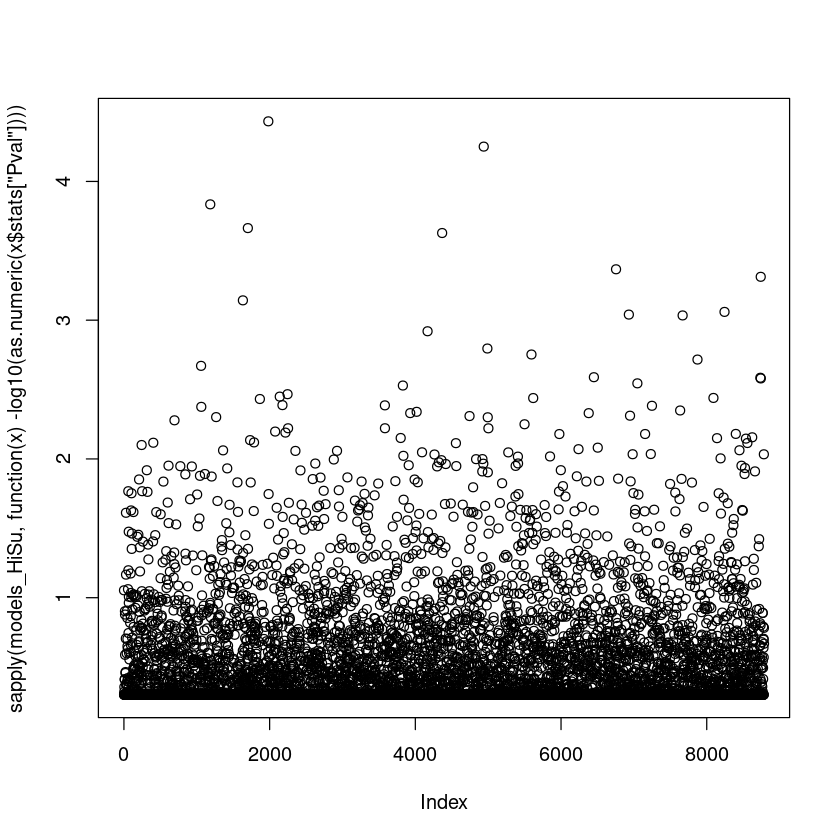

In [177]:
plot(sapply(models_HiSu, function(x) -log10(as.numeric(x$stats["Pval"]))))